# Google Earth Engine Component

## Initialize

In [1]:
#Import required libraries
import os
from time import time
from pprint import pprint
import math
import itertools

import ee
import geemap
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import keras_tuner

In [2]:
# Check number of available GPUs
n_gpus = len(tf.config.list_physical_devices('GPU'))
assert n_gpus >= 1
print("Num GPUs Available:", n_gpus)

Num GPUs Available: 1


2022-07-15 21:33:18.751536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 21:33:18.761984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 21:33:18.763914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
#Initialize Google Earth Engine
#just needed the 1st time
ee.Authenticate() 
ee.Initialize()

Enter verification code: 4/1AdQt8qi-z4UOcXRvi5F6ALu2xPBaiIFp5dCtbPhbvyxy48YeUdgPRlr-nN4

Successfully saved authorization token.


## Define Globals

In [4]:
# Define classes
CLASSES = ['water',
           'vegetation_trees',
           'vegetation_grass',
           'turf',
           'impervious',
           'soil']

N_CLASSES = len(CLASSES)

# Define the label and bands
LABEL = 'landcover'
NBANDS = ['R', 
         'G', 
         'B', 
         'N', 
         'NDVI',
         'N_Entropy', 
         'N_Contrast', 
         'N_Gearys']

ALL_BANDS = NBANDS + ['R_Entropy',
                      'R_Contrast',
                      'R_Gearys',
                      'G_Entropy',
                      'G_Contrast',
                      'G_Gearys',
                      'B_Entropy',
                      'B_Contrast',
                      'B_Gearys']

# Select desired band set
BANDS = ALL_BANDS

In [5]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Create Images for Map

### Load Feature Collections

In [6]:
#Data loads

#loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

#filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))
sc_county = counties.filter(ee.Filter.eq('NAME', 'Santa Clara'))

#loads parcel data
la_parcel_shape = ee.FeatureCollection("projects/california-lawn-detection/assets/LA_County_Parcels_Shape")

#Income Data
la_county_income = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome-final")
la_county_income2 = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome_update")
la_county_income = la_county_income2.select(ee.List(['Name', 'Descriptio', 'Ranking']), ee.List(['Name', 'Median_Income', 'Ranking']))

### Build Training Image

In [7]:
def apply_3bands(image, band):
    i_8_bit = image.select(band).toUint8()
    square = ee.Kernel.square(**{'radius': 4})
    entropy = i_8_bit.entropy(square)
    glcm = i_8_bit.glcmTexture(**{'size': 4})
    contrast = glcm.select(str(band)+'_contrast')
    
    # Create a list of weights for a 9x9 kernel.
    list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    # The center of the kernel is zero.
    centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
    # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
    lists = [list, list, list, list, centerList, list, list, list, list]
    # Create the kernel from the weights.
    # Non-zero weights represent the spatial neighborhood.
    kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)
    neighs = i_8_bit.neighborhoodToBands(kernel)
    gearys = i_8_bit.subtract(neighs).pow(2).reduce(ee.Reducer.sum()).divide(math.pow(9, 2))
    image = image.addBands(entropy.rename(str(band)+'_Entropy')).addBands(contrast.rename(str(band)+'_Contrast')).addBands(gearys.rename(str(band)+'_Gearys'))   
    return image

def add_neighborhood_bands(image):
    bands = ['R', 'G', 'B', 'N']
    for band in bands:
        image = apply_3bands(image, band)
    return image
    
def add_NDVI(image):
    image = image.addBands(image.normalizedDifference(['N','R']).rename('NDVI'))
    return image
     

In [8]:
def get_images(param_dict):
    source_image_collection = param_dict['source_image_collection']
    years = param_dict['years']
    counties = param_dict['counties']

    image_names = []
    images = []

    combos = list(itertools.product(years, counties.keys()))
    for i in combos:
        year = str(i[0])
        county = i[1]

        image_name = str(i[0])+'_'+i[1]
        image_names.append(image_name)

        image = ee.ImageCollection(source_image_collection)\
                                .filterDate(f'{year}-01-01', f'{year}-12-31')\
                                .select(['R','G','B','N'])\
                                .median().clip(counties[county])
        images.append(image)
        images_with_3band = list(map(add_neighborhood_bands, images))
        images_with_NDVI = list(map(add_NDVI, images_with_3band))
    return dict(zip(image_names, images_with_NDVI))

In [9]:
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'la_county': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_la_county']

In [10]:
Map.addLayer(TRAINING_IMAGE, {}, 'TRAINING_IMAGE')

In [11]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

## Read in CSV data

In [12]:
def read_data(file, classes=None):
    
    '''
    Read data and reshape for CNN input
    '''
        
    # Read in data and shuffle
    data = pd.read_csv(file).to_numpy()
    np.random.shuffle(data)

    # Split into X and Y
    X, Y = data[:,:-1], data[:, -1].astype(int)
    
    # Print class counts if labels are specified
    if classes:
        _, counts = np.unique(Y, return_counts=True)
        print(file)
        print(pd.DataFrame({'class': classes, 'counts': counts}))
        print()

    # Convert Y to sparse dataset
    sparse_Y = np.zeros((Y.size, Y.max()+1))
    sparse_Y[np.arange(Y.size), Y] = 1

    # Reshape for 1x1 kernel convolutions
    conv_X = X.reshape((X.shape[0], 1, 1, X.shape[1]))
    conv_sparse_Y = sparse_Y.reshape((sparse_Y.shape[0], 1, 1, sparse_Y.shape[1]))
        
    return conv_X, conv_sparse_Y

In [13]:
# File names for the training and testing datasets
IMAGES_DIR = '../datasets/GoogleEarth'
TRAIN_FILE_PREFIX = 'training_allbands_expanded_0709'
TEST_FILE_PREFIX = 'testing_allbands_expanded_0709' 

FILE_EXT = '.csv'
CSV_TRAIN_FILE_PATH = os.path.join(IMAGES_DIR, (TRAIN_FILE_PREFIX + FILE_EXT))
CSV_TEST_FILE_PATH = os.path.join(IMAGES_DIR, (TEST_FILE_PREFIX + FILE_EXT))

In [14]:
# Set the seed for data shuffle
np.random.seed(123)

conv_train_X, conv_sparse_train_Y = read_data(CSV_TRAIN_FILE_PATH, CLASSES)
conv_test_X, conv_sparse_test_Y = read_data(CSV_TEST_FILE_PATH, CLASSES)

../datasets/GoogleEarth/training_allbands_expanded_0709.csv
              class  counts
0             water    2336
1  vegetation_trees   68413
2  vegetation_grass  191787
3              turf    3290
4        impervious  233446
5              soil    8995

../datasets/GoogleEarth/testing_allbands_expanded_0709.csv
              class  counts
0             water     275
1  vegetation_trees    2801
2  vegetation_grass    1532
3              turf     860
4        impervious    1103
5              soil    9003



In [15]:
conv_train_X.shape, conv_sparse_train_Y.shape

((508267, 1, 1, 17), (508267, 1, 1, 6))

In [16]:
conv_test_X.shape, conv_sparse_test_Y.shape

((15574, 1, 1, 17), (15574, 1, 1, 6))

## Build NN models

### Custom F1 Metric

In [24]:
class MultiClassFBeta(keras.metrics.Metric):
    '''
    Define a custom F-beta metric class to optimize against
    during hyperparameter tuning. Class can perform F-beta calcutions
    for macro, weighted, and raw scores for any value of beta.
    
    Default is macro F1 score.
    '''
    
    def __init__(self,  n_class=N_CLASSES, name=None, beta=1, average='macro',
                 epsilon=1e-7, **kwargs):
        
        # If name is not provided, set default name
        if not name:
            name = f"{average}_f{beta}"
        print(name)

        # initializing an object of the Metric super class
        super(MultiClassFBeta, self).__init__(name=name, **kwargs)

        # initializing static variables 
        self.beta_squared = beta**2
        self.n_class = n_class
        self.average = average
        self.epsilon = epsilon

        # initializing state variables
        self.tp = self.add_weight(name='tp', 
                                  shape=(self.n_class,), 
                                  initializer='zeros')     # initializing true positives
        self.actual_positives = self.add_weight(name='ap', 
                                                shape=(self.n_class,), 
                                                initializer='zeros') # initializing actual positives
        self.predicted_positives = self.add_weight(name='pp',
                                                   shape=(self.n_class,), 
                                                   initializer='zeros') # initializing predicted positives

    
    def update_state(self, ytrue, ypred, sample_weight=None):

        '''
        Updates the metrics to preserve the running state
        '''

        # casting ytrue and ypred as float dtype
        ytrue = tf.cast(ytrue, tf.float32)
        ypred = tf.cast(ypred, tf.float32)

        # finding the maximum probability in ypred
        max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

        # making ypred one hot encoded such that the class with the maximum probability 
        # as encoded as 1 while others as 0
        ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)

        # Calculate TP, PP, AP
        TP = tf.reshape(tf.reduce_sum(ytrue*ypred, axis=0), [self.n_class])
        PP = tf.reshape(tf.reduce_sum(ypred, axis=0), [self.n_class])
        AP = tf.reshape(tf.reduce_sum(ytrue, axis=0), [self.n_class])

        self.tp.assign_add(TP) # updating true positives atrribute
        self.predicted_positives.assign_add(PP) # updating predicted positives atrribute
        self.actual_positives.assign_add(AP) # updating actual positives atrribute

    def result(self):
    
        '''
        Performs final metric computations and returns result
        '''

        self.precision = self.tp/(self.predicted_positives+self.epsilon) # calculates precision
        self.recall = self.tp/(self.actual_positives+self.epsilon) # calculates recall

        # calculating fbeta score
        self.fb = (1+self.beta_squared)*self.precision*self.recall / (self.beta_squared*self.precision + self.recall + self.epsilon)

        if self.average == 'weighted':
            return tf.reduce_sum(self.fb*self.actual_positives / tf.reduce_sum(self.actual_positives))

        elif self.average == 'raw':
            return self.fb

        return tf.reduce_mean(self.fb)

    def reset_state(self):
        
        '''
        Reset the tracked metrics (state)
        '''

        self.tp.assign(tf.zeros(self.n_class)) # resets true positives to zero
        self.predicted_positives.assign(tf.zeros(self.n_class)) # resets predicted positives to zero
        self.actual_positives.assign(tf.zeros(self.n_class)) # resets actual positives to zero

### KerasTuner

In [18]:
class CNNHyperModel(keras_tuner.HyperModel):

    """
    Custom CNN hyperparamater tuning model. 
    Inherits from keras_tuner HyperModel.
    """
    
    def __init__(self, n_features, n_classes):
        
        super(CNNHyperModel, self).__init__()
        
        self.n_features = n_features
        self.n_classes = n_classes
        

    def build(self, hp):
        
        '''
        Build the model with a range of hyperparameters for tuning.
        Current hyperparameters being tuned:
          - Activation functions
          - Learning rate
          - # hidden layers
          - Nodes (filters) per layer
          - Dropout per layer
          - Batch size
        '''
        
        # Define ranges for activations, learning rate, and # hidden layers 
        activation = hp.Choice("activation", ["relu", "tanh"])
        lr = hp.Choice("lr", [1e-4, 3e-4, 6e-4, 1e-3, 3e-3, 6e-3, 1e-2])
        hidden_layers = hp.Int("layers", min_value=1, max_value=3)
        
        
        # Set model input shape
        model = keras.Sequential()
        model.add(layers.Input((None, None, self.n_features,)))
        
        # For each hiden layer, set the number of nodes/filters and dropout
        for i in range(hidden_layers):
            
            nodes = hp.Int(f"nodes_{i+1}", min_value=8, max_value=64, step=8)
            model.add(layers.Conv2D(nodes, (1,1), activation=activation))
        
            dropout_rate = hp.Float(f"dropout_rate_{i+1}", min_value=0.0, max_value=0.5, step=0.05)
            model.add(layers.Dropout(dropout_rate))
 
        # Add the final output layer
        model.add(layers.Conv2D(self.n_classes, (1,1), activation=tf.nn.softmax))
        
        # Compile the model with the specified loss function, metrics, and learning rate
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=[MultiClassFBeta(n_class=self.n_classes), 'accuracy'])
        
        # Print model architecture
        print(model.summary())
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        
        '''
        Fit model on data and tune batch size
        '''
        
        return model.fit(
            *args,
            batch_size=hp.Int("batch_size", min_value=16, max_value=126, step=8),
            **kwargs,
        )

## Training pipeline

In [19]:
def tune_model(train_X, train_Y, test_X, test_Y, obj, tuning_dir=None, project_name='CNN', 
               epochs=20, patience=3, search_type='Bayesian', 
               max_trials=10, per_trial=2, bayesian_beta=2, new_search=False):
    
    '''
    Function to perform hyperparameter search.
    
    Params
    ------
    train_X : np.array
        Train dataset feature matrix
    train_Y : np.array
        Train dataset labels matrix
    test_X : np.array
        Test dataset feature matrix
    test_Y : np.array
        Test dataset labels matrix
    obj: str | keras_tuner.Objective
        The objective to optimize for
    tuning_dir: str
        Path to store tuning trials (defaults to 'path/to/current/parent_directory/model_tuning/')
    project_name: str
        Directory under tuning_dir to store model tuning results (defaults to 'CNN')
    epochs: int
        Max number of epochs to train (defaults to 20)
    patience: int
        Patience for EarlyStopping callback (defaults to 3)
    search_type: str
        Hyperparameter search type, either 'Random' or 'Bayesian' (defaults to 'Bayesian')
    max_trials: int
        Maximum number of search trials (defaults to 10)
    per_trial: int
        The number of models that should be built and fit for each trial (defaults to 2)
    bayesian_beta: int
        The balancing factor of exploration and exploitation. 
        The larger it is, the more explorative it is. (defaults to 2)
    new_search: bool
        Whether to overwrite the previous results in the same directory 
        or resume the previous search. (defaults to False)


    Returns
    -------
    CNN_tuner: keras_tuner
        The fitted Keras Tuner that stores the results of the 
        hyperparameter tuning and the associated models.
    '''
    
    
    # Get input and output shapes for the CNN model
    n_features = train_X.shape[-1]
    n_classes = train_Y.shape[-1]
    
    # Specify the default tuning directory
    if not tuning_dir:
        tuning_dir = os.path.join(os.path.dirname(os.getcwd()), "model_tuning")
        tuning_dir

    # Use GPU 
    with tf.device('/device:GPU:0'):
        
        model = CNNHyperModel(n_features=n_features, n_classes=n_classes)
        
        # Random search
        if search_type=='Random':
            CNN_tuner = keras_tuner.RandomSearch(
                hypermodel=model,
                objective=keras_tuner.Objective("val_macro_f1", direction="max"),
                max_trials=max_trials,
                executions_per_trial=per_trial,
                overwrite=new_search,
                directory=tuning_dir,
                project_name=project_name,
            )
        
        
        # BayesianSearch
        elif search_type=='Bayesian':
                CNN_tuner = keras_tuner.BayesianOptimization(
                hypermodel=model,
                objective=keras_tuner.Objective("val_macro_f1", direction="max"),
                max_trials=max_trials,
                beta=bayesian_beta,
                executions_per_trial=per_trial,
                overwrite=new_search,
                directory=tuning_dir,
                project_name=project_name,
            )
        
        # If neither search type is specified, raise an error
        else:
            raise ValueError("search_type must be either 'Random' or 'Bayesian'")
            
        # Fit the hyperparameter tuner
        CNN_tuner.search(x=train_X, y=train_Y, 
                         verbose=2, validation_data=(test_X, test_Y), 
                         epochs=epochs, callbacks=[keras.callbacks.EarlyStopping('val_macro_f1', 
                                                                             patience=patience, 
                                                                             mode='max', 
                                                                             restore_best_weights=True)]
                        )
        
    return CNN_tuner
    

In [20]:
def save_best_models(tuner, model_names, n_models=1, model_dir=None):
    
    '''
    Save the best N models to a directory and return the save path
    '''
    
    # Get the best N models
    best_models = tuner.get_best_models()[:n_models]

    # Default model directory
    if not model_dir:
        model_dir = os.path.join(os.path.dirname(os.getcwd()), "models")
        
    if isinstance(model_names, str):
        model_names = list(model_names)
    
    # Save the best N models
    for model, model_name in zip(best_models, model_names):
        save_dir = os.path.join(model_dir, model_name)
        model.save(save_dir)
        
    return save_dir

In [ ]:
# Define hyperparameter tuning params
results_dir = 'just_a_test' 
epochs=30
max_trials=20
new_search=False
per_trial=1
objective = keras_tuner.Objective("val_macro_f1", direction="max")

# Start hyperparameter search
CNN_tuner = tune_model(conv_train_X, conv_sparse_train_Y, conv_test_X, conv_sparse_test_Y,
                       objective, project_name=results_dir, epochs=epochs, 
                       max_trials=max_trials, per_trial=per_trial, new_search=new_search)


Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
tanh              |relu              |activation
0.0001            |0.0006            |lr
1                 |1                 |layers
64                |64                |nodes_1
0.5               |0                 |dropout_rate_1
120               |120               |batch_size
64                |64                |nodes_2
0.5               |0                 |dropout_rate_2

macro_f1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    1152      
                                                                 
 dropout (Dropout)           (None, None, None, 64)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 6)     390       
                                             

In [26]:
# Save the best performing model
model_name = f'just_a_test_model_{time():.0f}'
save_dir = save_best_models(CNN_tuner, model_name)

print(f"Best N models saved at: {save_dir}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    1152      
                                                                 
 dropout (Dropout)           (None, None, None, 64)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 6)     390       
                                                                 
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
_________________________________________________________________
None


2022-07-12 03:19:57.028717: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/ec2-user/mids-w210-capstone/models/CNN_allbands_model_1657595997/assets


In [24]:
# save_dir = '/home/ec2-user/mids-w210-capstone/models/CNN_Nbands_model_1657535394'

In [27]:
# Load and evaluate model to test it's the same performance

best_nn_model = tf.keras.models.load_model(save_dir, custom_objects={'MultiClassFBeta': MultiClassFBeta})
best_nn_model.evaluate(conv_test_X, conv_sparse_test_Y)

487/487 [==============================] - 1s 2ms/step - loss: 0.4294 - macro_f1: 0.8332 - accuracy: 0.8528


[0.42944878339767456, 0.8332240581512451, 0.8527674078941345]

## Evaluate model

In [30]:
def get_classification_report(model, X, y_true, class_names, save_dir=None):
    
    # Get model predictions
    y_probs = model.predict(X)
    y_preds = y_probs.argmax(axis=-1)

    # If conv output, convert to 1d array
    if len(y_preds.shape) > 2:
        y_preds = y_preds.reshape(-1, 1)
        
    # If conv input, convert Y to 1d array
    if len(y_true.shape) > 2:
        n_classes = y_true.shape[-1]
        y_true = np.argmax(y_true.reshape(-1, n_classes), axis=1)
    
    # Get the classification report
    report = classification_report(test_Y, y_preds, target_names=class_names)
    
    # Save the report if directory specified
    if save_dir:
        save_report = classification_report(test_Y, y_preds, target_names=class_names, 
                                            output_dict=True)
        df = pd.DataFrame(save_report).transpose()
        df.to_csv(save_dir)
    
    return report, y_true, y_preds

In [33]:
def create_cmap(R, G, B, increasing_gradient=True, color_scale=256, mult=1):
    
    # Initialize colormap array
    color_vals = np.ones((color_scale, 4))
    
    # Calculate pixel value range for R,G,B
    R_start, R_end = R+(1-R)*(1-mult), R+(1-R)*(mult)
    G_start, G_end = G+(1-G)*(1-mult), G+(1-G)*(mult)
    B_start, B_end = B+(1-B)*(1-mult), B+(1-B)*(mult)
    
    bands = [(R_start, R_end), (G_start, G_end), (B_start, B_end)]

    # Create range of pixel values for R,G,B
    for i, color in enumerate(bands):   
        color_vals[:, i] = np.linspace(*color, color_scale)
        if increasing_gradient:
            color_vals[:, i] = color_vals[:, i][::-1]
    
    # Create colormap
    cmap = ListedColormap(color_vals)
    
    return cmap    

In [31]:
def plot_confusion_matrix(y_true, y_preds, save_cm_dir=None, **kwargs):
    
    # Plot the CM
    ConfusionMatrixDisplay.from_predictions(y_true, y_preds, **kwargs)
    plt.show()
    
    # Save the CM if directory specified
    if save_cm_dir:
        plt.savefig(save_cm_dir)

In [31]:
# Get the classification report and save it
report_path = os.path.join(save_dir, 'classification_report.csv')
report, y_true, y_preds = get_classification_report(best_nn_model, conv_test_X, conv_sparse_test_Y,
                                                   CLASSES, save_dir=report_path)

print(report)

NameError: name 'create_cmap' is not defined

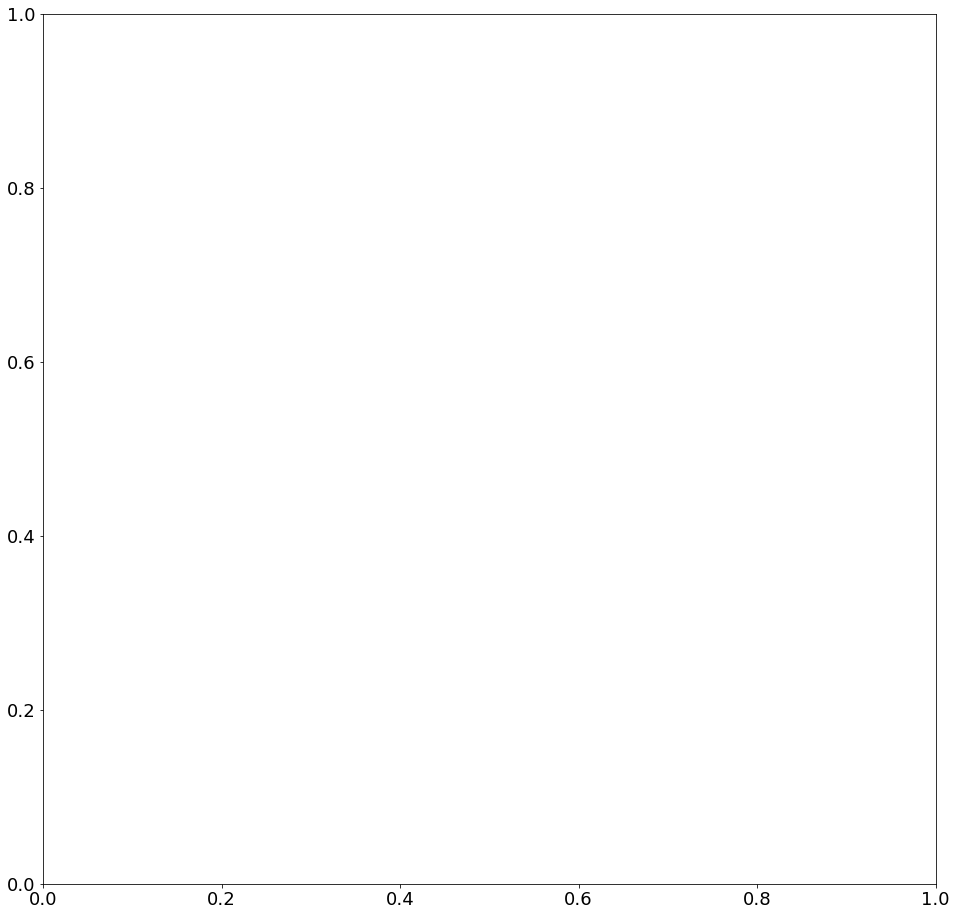

In [32]:
plt.rcParams.update({'text.color': "black",
                     'font.size' : 18,
                     })

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)

# Create brown colormap
brown_R = 90/256
brown_G = brown_B = 40/256
mult = 0.75

brown_cmp = create_cmap(brown_R, brown_G, brown_B, mult=mult)

# Plot the confusion matrix and save the figure
cm_path = os.path.join(save_dir, 'confusion_matrix.png')

plot_confusion_matrix(y_true, y_preds, save_cm_dir=cm_path,
                      display_labels=CLASSES, ax=ax, normalize='true', 
                      cmap=brown_cmp, xticks_rotation=30)

## EEificiation

In [33]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(save_dir, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "output"}) + "'"
print(input_dict)
print(output_dict)

'{"serving_default_input_1:0": "array"}'
'{"StatefulPartitionedCall:0": "output"}'


In [34]:
# Put the EEified model in the appropriate bucket and API name
PROJECT = 'w210-351617'
OUTPUT_BUCKET = 'test-tf-gee'
EEIFIED_DIR = 'gs://' + OUTPUT_BUCKET + '/eeified_pixel_model'

MODEL_NAME = results_dir
VERSION_NAME = 'v0'
REGION = 'us-central1'

In [35]:
# Run the model prepare commands
!earthengine set_project {PROJECT}
!earthengine model prepare --source_dir {save_dir} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

Successfully saved project id
Success: model at 'gs://test-tf-gee/eeified_pixel_model' is ready to be hosted in AI Platform.


In [36]:
# Create API endpoint hosted on Google AI Platform
!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT} \
  --region {REGION}

!gcloud ai-platform versions create {VERSION_NAME} \
  --project {PROJECT} \
  --region {REGION} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --framework "TENSORFLOW" \
  --runtime-version=2.3 \
  --python-version=3.7

Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/w210-351617/models/CNN_allbands_expanded_full].
Using endpoint [https://us-central1-ml.googleapis.com/]
Creating version (this might take a few minutes)......done.                    


## Visualize model predictions

In [ ]:
def get_TF_classified_image(image, bands, tf_model, classes):
    
    '''
    Use a TF model hosted on Google AI Platform to classify an EE image.
    '''
    
    # Select bands from training image for classification
    selected_image = image.select(bands)

    # Get the predictions
    predictions = tf_model.predictImage(selected_image.float().toArray())
    probabilities = predictions.arrayFlatten([classes])
    classified_image = predictions.arrayArgmax().arrayGet([0]).rename('classification')
    
    return classified_image

In [ ]:
# Point to the specific TF model to be used for inference
PROJECT = 'w210-351617'
MODEL_NAME = 'CNN_Nbands_model'
VERSION_NAME = 'v0'
input_dim = [12,12]

# Point to the model hosted on AI Platform.
tf_model = ee.Model.fromAiPlatformPredictor(
    projectName=PROJECT,
    modelName=MODEL_NAME,
    version=VERSION_NAME,
    # Can be anything, but don't make it too big.
    inputTileSize=input_dim,
    # Note the names here need to match what was specified in the
    # output dictionary passed to the EEifier originally
    outputBands={'output': {
        'type': ee.PixelType.float(),
        'dimensions': 1
      }
    },
)

In [45]:
# Classify the training image
training_image_classified = get_TF_classified_image(TRAINING_IMAGE, BANDS, tf_model, CLASSES)

assert(training_image_classified.bandNames().getInfo() == ['classification'])

In [46]:
legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']

Map.addLayer(training_image_classified, {'min': 0, 'max': 5, 'palette': legend_colors}, 'Classification')

In [47]:
Map

Map(bottom=3352500.0, center=[33.956745298141946, -118.26524842010575], controls=(WidgetControl(options=['posi…